In [1]:
#Import required packages
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
#Declare base
Base = automap_base()

In [5]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
#Create inspector
inspector = inspect(engine)

In [9]:
#View the columns of the Measurement table
columns_m = inspector.get_columns('measurement')

for i in columns_m:
    print(i['name'], i['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#View the columns of the Station table
columns_s = inspector.get_columns('station')

for i in columns_s:
    print(i['name'], i['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

recent_date

('2017-08-23',)

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
year_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
plot_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
plot_df = pd.DataFrame(plot_data, columns=["Date", "Precipitation"])
plot_df = plot_df.dropna(how='any')

plot_df.sort_values('Precipitation', ascending=False)

,Date,Precipitation
144,2016-09-14,170.2
1571,2017-04-29,158.8
1093,2017-02-11,128.0
2081,2017-07-22,101.6
274,2016-10-04,87.9
...,...,...
955,2017-01-21,0.0
1558,2017-04-27,0.0
954,2017-01-20,0.0
953,2017-01-20,0.0


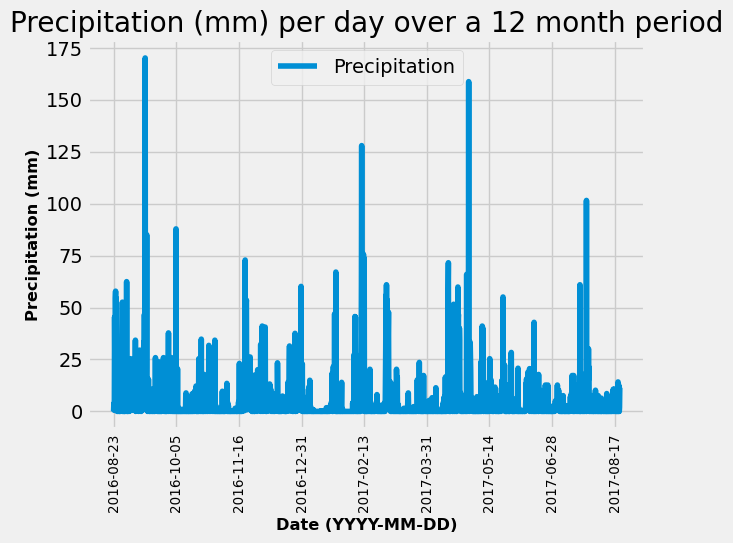

In [83]:
# Use Pandas Plotting with Matplotlib to plot the data
figure_1 = plot_df.plot(x='Date', y='Precipitation', title="Precipitation (mm) per day over a 12 month period")
plt.xlabel("Date (YYYY-MM-DD)", fontweight='bold', fontsize='small')
plt.ylabel("Precipitation (mm)", fontweight='bold', fontsize='small')
plt.xticks(rotation=90, fontsize='x-small')

plt.legend()
plt.show()

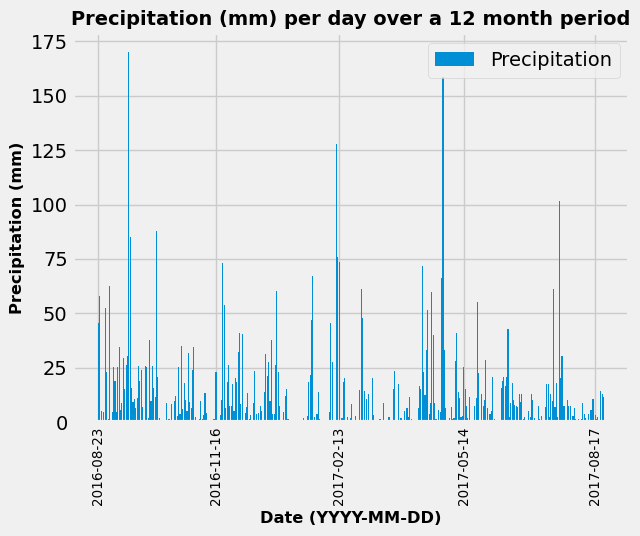

In [65]:
# Use Matplotlib to plot the data
plt.bar(plot_df['Date'], plot_df['Precipitation'], label="Precipitation")
plt.title("Precipitation (mm) per day over a 12 month period", fontweight='bold', fontsize='medium')
plt.xlabel("Date (YYYY-MM-DD)", fontweight='bold', fontsize='small')
plt.ylabel("Precipitation (mm)", fontweight='bold', fontsize='small')

#Set x ticks
ticks = list(plot_df['Date'])
plt.xticks([ticks[i] for i in range(len(ticks)) if i % 500 == 0], rotation='90', fontsize='x-small')

#Set y ticks
plt.yticks(np.arange(0, 180, 25))

#Save and display plot
plt.legend()
# plt.savefig("Precipitation (mm) per day over a 12 month period.png")
plt.show()

In [45]:
# Use Pandas to calculate the summary statistics for the precipitation data
plot_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).distinct().count()

station_count

9

In [47]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

most_active_stats

[(12.2, 29.4, 22.03582251082252)]

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Obtain the temperature data for the last 12 months
hist_data = session.query(Measurement.tobs).filter(Measurement.station == most_active).\
    filter(Measurement.date >= year_date).order_by(Measurement.date).all()

hist_df = pd.DataFrame(hist_data, columns=["Temperature"])
hist_df = hist_df.dropna(how='any')

hist_df.head()

,Temperature
0,25.0
1,25.0
2,26.7
3,26.7
4,23.9


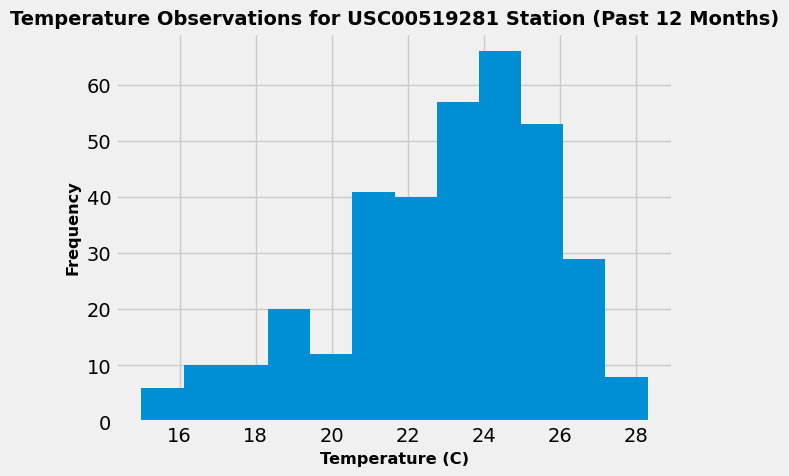

In [52]:
#Plot temperature data as a histogram
plt.hist(hist_df["Temperature"], bins=12, label=("tobs"))
plt.title(f"Temperature Observations for {most_active} Station (Past 12 Months)", fontweight='bold', fontsize='medium', wrap=True)
plt.xlabel("Temperature (C)", fontweight='bold', fontsize='small')
plt.ylabel("Frequency", fontweight='bold', fontsize='small')

#Save and Display plot
# plt.savefig("Temperature Observations for Most Active Station (Past 12 Months).png")
plt.show()

# Close Session

In [53]:
# Close Session
session.close()